# Pixel classification
* update: 04/22/2020
* by Mike Chien-Cheng Shih

In [1]:
import os, sys
import itertools
import numpy as np

# image
from imutils import paths
import cv2
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk

# figure
import matplotlib.pyplot as plt

# metadata
import uuid
import json
from pprint import pprint
from datetime import datetime

# tensorboard
from tensorboard.plugins.hparams import api as hp

# customized function
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.mlseg import create_training_dataset, create_binary_pattern, create_predict_dataset

from numpy.lib import stride_tricks
import mahotas as mt
import time
import pickle as pkl
import progressbar
import argparse
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm.notebook import trange

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

%load_ext autoreload
%autoreload 2

In [2]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# input set
# crop_input_set = '2020_01_23_09_51_20x'
crop_input_set = '2020_02_06_14_42_20x' # small training set

imginput = os.path.join('dl_seg_project_raw', 'data_crop', crop_input_set,)
imgpath = os.path.join(path, imginput)

print('input imgpath: {}'.format(imgpath))

img_dir = os.path.join(imgpath, 'images')
label_dir = os.path.join(imgpath, 'labels')

print('image dir: {}'.format(img_dir))
print('label dir: {}'.format(label_dir))

# create input file list
imgpath_all = list(paths.list_images(img_dir))
labelpath_all = list(paths.list_images(label_dir))

Load Images...
input imgpath: D:PerlmutterData\dl_seg_project_raw\data_crop\2020_02_06_14_42_20x
image dir: D:PerlmutterData\dl_seg_project_raw\data_crop\2020_02_06_14_42_20x\images
label dir: D:PerlmutterData\dl_seg_project_raw\data_crop\2020_02_06_14_42_20x\labels


In [3]:
print(imgpath_all[0])
print(len(imgpath_all))
print(labelpath_all[0])
print(len(labelpath_all))

D:PerlmutterData\dl_seg_project_raw\data_crop\2020_02_06_14_42_20x\images\nucleus\0001.tif
6620
D:PerlmutterData\dl_seg_project_raw\data_crop\2020_02_06_14_42_20x\labels\nucleus\0001.tif
6620


In [4]:
# create subset to 50
imgpath_all = imgpath_all[:100]
labelpath_all = labelpath_all[:100]

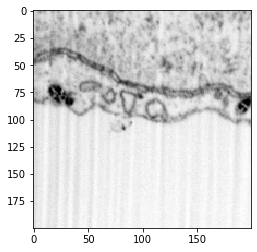

In [5]:
img_tmp = imread(imgpath_all[0], as_gray = True)
plt.imshow(img_tmp, cmap='gray')

(200, 200, 100)
[[201 198 189 ... 183 162 168]
 [201 201 195 ... 189 177 171]
 [192 192 192 ... 180 180 171]
 ...
 [204 207 207 ... 228 225 228]
 [207 207 213 ... 231 231 222]
 [204 201 204 ... 225 225 228]]


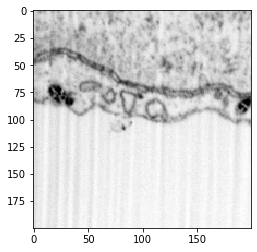

In [6]:
z = len(imgpath_all)
y, x = img_tmp.shape

# load image
img_stack = np.empty([y, x, z], dtype = 'uint8')
print(img_stack.shape)
for idx, filepath in enumerate(imgpath_all):
    img_stack[:, :, idx] = np.uint8(imread(filepath, as_gray = True))
plt.imshow(img_stack[:, :, 0], cmap='gray')
print(img_stack[:, :, 0])

(200, 200, 100)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


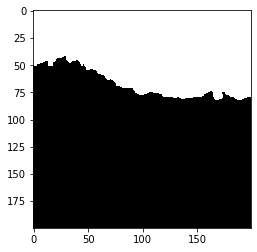

In [7]:
# load label
label_stack = np.empty([y, x, z], dtype = 'uint8')
print(label_stack.shape)
for idx, filepath in enumerate(labelpath_all):
    img_tmp = imread(filepath, as_gray = True)
    img_tmp[img_tmp > 0] = 1
    label_stack[:, :, idx] = img_tmp
plt.imshow(label_stack[:, :, 0], cmap='gray')
print(label_stack[:, :, 0])

In [8]:
n_samples = (label_stack > 0).sum()
print(n_samples)

1382615


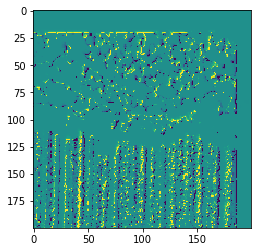

In [9]:
lbp_radius = 24
lbp_points = lbp_radius * 8

img_lbp = create_binary_pattern(img_stack[:, :, 0], lbp_points, lbp_radius)
plt.imshow(img_lbp)

In [10]:
def train_model(X, y, classifier):

    if classifier == "SVM":
        print ('Training Support Vector Machine model')
        model = SVC()
        model.fit(X, y)
    elif classifier == "RF":
        print ('Training Random Forest model')
        model = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
        model.fit(X, y)

    print('Model training complete.')
    print('Training Accuracy: %.2f' %model.score(X, y))
    return model

In [11]:
def test_model(X, y, model):

    pred = model.predict(X)
    accuracy = metrics.accuracy_score(y, pred)
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))

    print('--------------------------------')
    print('Results')
    print('Accuracy: %.2f' %accuracy)
    print('Precision: %.2f' %precision)
    print('Recall: %.2f' %recall)
    print('F1: %.2f' %f1)
    print('--------------------------------')

    return pred

In [12]:
def main(img_stack, label_stack, classifier):
    
    start = time.time()
    
    # Prepare data
    X_train, X_test, y_train, y_test = create_training_dataset(img_stack, label_stack)
    
    # trian model
    model = train_model(X_train, y_train, classifier)
    
    # save model
    output_model = 'data_' + classifier + '.pkl'
    pkl.dump(model, open(output_model, "wb"))

    # test model
    pred = test_model(X_test, y_test, model)
    print ('Processing time:',time.time()-start)

    return model

In [13]:
model_RF = main(img_stack, label_stack, "RF")

Creating training dataset
Amount of images: 100


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[                                                                        ] N/A%

Computing haralick features.


[                                                                        ]   1%

Computing haralick features.


[========================================================================] 100%


Feature vector size: (80000, 11)
Training Random Forest model
Model training complete.
Training Accuracy: 0.93
--------------------------------
Results
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1: 0.91
--------------------------------
Processing time: 1476.3747210502625


Creating predict dataset
Amount of images: 1


[                                                                        ] N/A%

(200, 200, 2)
(190, 190, 2)
Computing haralick features.


[======================================================================= ]  98%

(36100, 11)

(36100, 11)
(36100,)


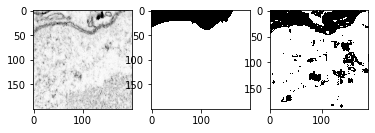

In [16]:
test_img = img_stack[:, :, 30]
test_img = test_img.reshape(200, 200, 1)
X = create_predict_dataset(test_img)
print(X.shape)
pred = model_RF.predict(X)
print(pred.shape)
pred_img = pred.reshape(190, 190)


plt.subplot(131)
plt.imshow(test_img[:, :, 0], cmap=plt.cm.Greys_r)
plt.subplot(132)
plt.imshow(label_stack[:, :, 30], cmap=plt.cm.Greys_r)
plt.subplot(133)
plt.imshow(pred_img, cmap=plt.cm.Greys_r)

plt.show()